## precipitation extremes and org - one model + obs

In [6]:
import xarray as xr
import numpy as np
import skimage.measure as skm
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import cartopy
# import cartopy.crs as ccrs
# import cartopy.feature as cfeat

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)


from os.path import expanduser
home = expanduser("~")

In [ ]:
def plot_snapshot(scene, cmap, title, vmin=None, vmax=None):
    projection = ccrs.PlateCarree(central_longitude=180)
    lat = scene.lat
    lon = scene.lon

    f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(20, 10))
    scene.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal','pad':0.125, 'aspect':50,'fraction':0.055}, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.add_feature(cfeat.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.set_title(title)
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels([0, 90, 180, 270, 360])
    ax.set_yticks([-20, 0, 20])
    plt.tight_layout()

In [10]:
def plot_sceneThreshold(scene1, scene2, cmap1, cmap2, title):
    fig= plt.figure(figsize=(20,7.5))
    lat = scene1.lat
    lon = scene1.lon
    lonm,latm = np.meshgrid(lon,lat)
    ax = fig.add_subplot(projection=cartopy.crs.PlateCarree(central_longitude=180))
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=cartopy.crs.PlateCarree())

    pcm= ax.pcolormesh(lonm,latm, scene1, transform=cartopy.crs.PlateCarree(),zorder=0, cmap=cmap1)
    ax.pcolormesh(lonm,latm, scene2, transform=cartopy.crs.PlateCarree(), cmap=cmap2)

    ax.set_title(title)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')

    ax.set_yticks([-20, 0, 20])
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels([0, 90, 180, 270, 360])

    plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.10, aspect=50, fraction=0.055, label = 'pr [mm/day]')

In [25]:
def plot_scatter(x,y,title):
    f, ax = plt.subplots(figsize = (12.5,8))
    res= stats.pearsonr(x,y)

    plt.scatter(x,y,facecolors='none', edgecolor='k')
    plt.ylabel(prE_option + ' [' + y.units +']')
    plt.xlabel(org_option + ' ['+ x.units +']')
    
    if res[1]<=0.05:
        plt.title(title + ',  R$^2$ = '+ str(round(res[0]**2,3)) + ',  r = ' + str(round(res[0],3)))
    else:
        plt.title(title + ', not statistically significant')

In [26]:
def plot_bins(x,y, title, label):    
    bin_width = (x.max() - x.min())/100
    bin_end = x.max()
    bins = np.arange(0, bin_end+bin_width, bin_width)

    plt.title(title)
    plt.ylabel(prE_option + ' ['+ y.units +']')
    plt.xlabel('bins (Nb)')

    # plt.xlabel(org_option + ' ['+ x.units +']')

    res= stats.pearsonr(x,y)

    if res[1]<=0.05:
        ax.annotate('R$^2$: '+ str(round(res[0]**2,3)), xy=(0.2, 0.1), xycoords='axes fraction', xytext=(0.05, 0.875), textcoords='axes fraction')


    y_bins = []
    for i in np.arange(0,len(bins)-1):
        y_bins = np.append(y_bins, y.where((x>=bins[i]) & (x<=bins[i+1])).mean())
    plt.plot(y_bins, label = label)
    plt.legend(loc='lower right')

In [27]:
def plot_timeseriesHighlight(x, y, threshold, series_type, title):
    f, ax = plt.subplots(figsize=(25,5))

    ax.plot(y, label= prE_option)
    ax.scatter(x,y[x],label=org_option + ' ' + str(threshold) + 'th percentile', color='r')
    plt.axhline(y=y.mean(), color='k')

    plt.title(title)
    plt.ylabel(prE_option + ' [mm/day]')
    plt.xlabel(series_type)
    ax.legend()

In [4]:
models = [
    # ''
    # 'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    # 'GISS-E2-H',    # 3
    # 'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 # cannot concatanate files for rcp85 run
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    ]
model = models[0]

observations = [
    'GPCP'
    # ''
    ]
obs = observations[0]

experiments = [
    'historical',
    # 'rcp85'
    ]
experiment = experiments[0]     

org_options = [
    # 'rome',
    'rome_n',
    # 'o_number'
    ]
org_option = org_options[0]

prE_options = [
    'pr99',
    # 'rx1day',
    # 'rx5day'
    ]
prE_option = prE_options[0]


if model:
    folder = home + '/Documents/data/cmip5/ds'
    fileName = model + '_precip_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    precip = ds.precip*60*60*24
    precip.attrs['units']= 'mm/day'
    aWeights = np.cos(np.deg2rad(precip.lat))

    if org_option == 'rome' or org_option == 'rome_n':
        folder = home + '/Documents/data/cmip5/' + model
        fileName = model + '_rome_' + experiment + '.nc'
        path = folder + '/' + fileName
        ds = xr.open_dataset(path)
        org = ds[org_option]

    if org_option == 'o_number':
        folder = home + '/Documents/data/cmip5/' + model
        fileName = model + '_numberIndex_' + experiment + '.nc'
        path = folder + '/' + fileName
        ds = xr.open_dataset(path)
        org = ds[org_option]

    if prE_option == 'pr99': 
        folder = home + '/Documents/data/cmip5/' + model
        fileName = model + '_pr_percentiles_' + experiment + '.nc'
        path = folder + '/' + fileName
        ds = xr.open_dataset(path)
        prE = ds[prE_option]

    if prE_option == 'rx1day' or prE_option == 'rx5day':
        folder = home + '/Documents/data/cmip5/' + model
        fileName = model + '_pr_rxday_' + experiment + '.nc'
        path = folder + '/' + fileName
        ds = xr.open_dataset(path)
        prE = ds[prE_option]
        prE.attrs['units']= 'mm/day'


if obs:
    folder = home + '/Documents/data/obs/ds'
    fileName = 'GPCP_precip.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    precip_obs = ds.precip
    aWeights = np.cos(np.deg2rad(precip_obs.lat))

    if org_option == 'rome' or org_option == 'rome_n':
        folder = home + '/Documents/data/obs/' + obs
        fileName = obs + '_rome.nc'
        path = folder + '/' + fileName
        ds = xr.open_dataset(path)
        org_obs = ds[org_option]

    if org_option == 'o_number':
        folder = home + '/Documents/data/obs/' + obs
        fileName = obs + '_numberIndex.nc'
        path = folder + '/' + fileName
        ds = xr.open_dataset(path)
        org_obs = ds[org_option]

    if prE_option == 'pr99':
        folder = home + '/Documents/data/obs/' + obs
        fileName = obs + '_pr_percentiles.nc'
        path = folder + '/' + fileName
        ds = xr.open_dataset(path)
        prE_obs = ds[prE_option]

    if prE_option == 'rx1day' or prE_option == 'rx5day':
        folder = home + '/Documents/data/obs/' + obs
        fileName = obs + '_rxday.nc'
        path = folder + '/' + fileName
        ds = xr.open_dataset(path)
        prE_obs = ds[prE_option]
        prE_obs.attrs['units']= 'mm/day'

## Examples of precipitation extremes

### prPercentile, convective regions example

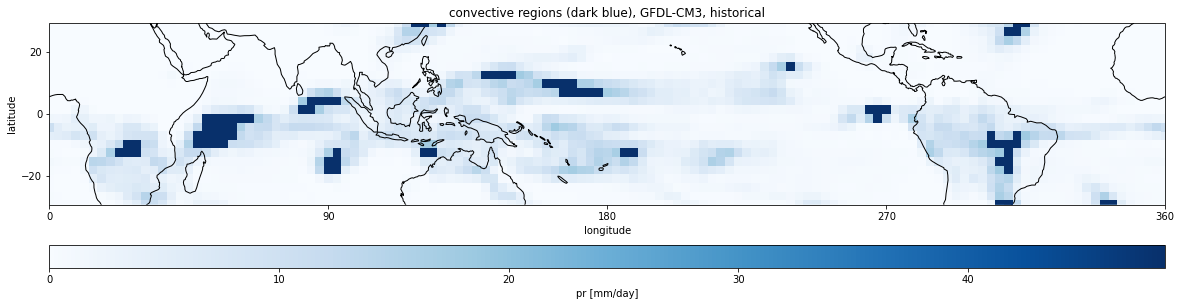

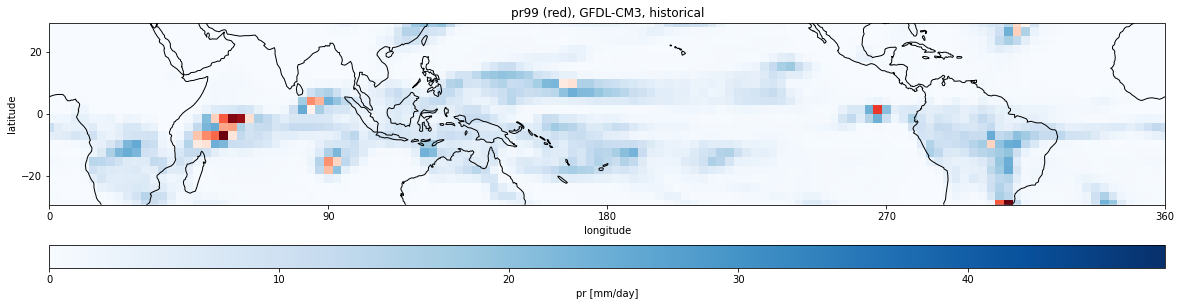

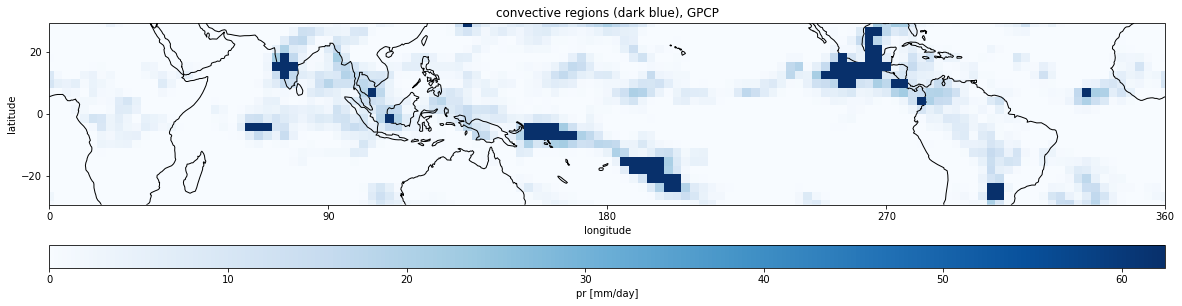

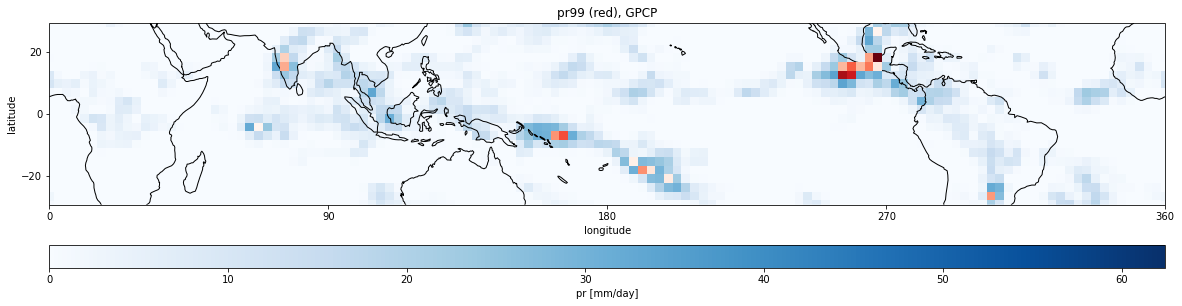

In [11]:
if prE_option == 'pr99': 
    day = 0
    if model:
        scene1 = precip.isel(time=day)
        threshold = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_percentiles_' + experiment + '.nc').pr97.mean(dim='time').values
        L = skm.label(scene1.where(scene1>=threshold,0)>0, background=np.nan,connectivity=2)
        L = (L>0)*1
        labelMatrix = xr.DataArray(
            data=L,
            dims=['lat', 'lon'],
            coords={'lat': scene1.lat.data, 'lon': scene1.lon.data}
            )
        scene2 = labelMatrix.where(labelMatrix>0)
        cmap1= 'Blues'
        cmap2 = 'Blues_r'
        title = 'convective regions (dark blue), ' + model + ', ' + experiment

        plot_sceneThreshold(scene1, scene2, cmap1, cmap2, title)


        scene1 = precip.isel(time=day)
        threshold = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_percentiles_' + experiment + '.nc').pr99.isel(time=day).values
        scene2 = scene1.where(scene1>threshold)
        cmap1= 'Blues'
        cmap2 = 'Reds'
        title = 'pr99 (red), ' + model + ', ' + experiment

        plot_sceneThreshold(scene1, scene2, cmap1, cmap2, title)


    if obs:
        scene1 = precip_obs.isel(time=day)
        threshold = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_pr_percentiles.nc').pr97.mean(dim='time').values
        L = skm.label(scene1.where(scene1>=threshold,0)>0, background=np.nan,connectivity=2)
        L = (L>0)*1
        labelMatrix = xr.DataArray(
            data=L,
            dims=['lat', 'lon'],
            coords={'lat': scene1.lat.data, 'lon': scene1.lon.data}
            )
        scene2 = labelMatrix.where(labelMatrix>0)
        cmap1= 'Blues'
        cmap2 = 'Blues_r'
        title = 'convective regions (dark blue), GPCP'

        plot_sceneThreshold(scene1, scene2, cmap1, cmap2, title)

        scene1 = precip_obs.isel(time=day)
        threshold = xr.open_dataset(home + '/Documents/data/obs/' + obs + '/' + obs + '_pr_percentiles.nc').pr99.isel(time=day).values
        scene2 = scene1.where(scene1>threshold)
        cmap1= 'Blues'
        cmap2 = 'Reds'
        title = 'pr99 (red), GPCP'

        plot_sceneThreshold(scene1, scene2, cmap1, cmap2, title)

### rxday example

In [30]:
if prE_option == 'rx1day' or prE_option == 'rx5day':
    if model:
        ds = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_pr_rxday_' + experiment + '.nc')

        scene = ds.rx1day.mean(dim='time')
        cmap = 'Blues'
        title = 'rx1day, ' + model + ', ' + experiment
        vmin = 0
        vmax = scene.max().values

        plot_snapshot(scene, cmap, title, vmin, vmax)

        scene = ds.rx5day.mean(dim='time')
        cmap = 'Blues'
        title = 'rx5day, ' + model + ', ' + experiment

        plot_snapshot(scene, cmap, title, vmin, vmax)


    if obs:
        ds = xr.open_dataset(home + '/Documents/data/obs/GPCP' + '/' + 'GPCP_rxday.nc')

        scene = ds.rx1day.mean(dim='time')
        cmap = 'Blues'
        title = 'rx1day, GPCP'
        vmin = 0
        vmax = scene.max(dim=('lat','lon')).values

        plot_snapshot(scene, cmap, title, vmin, vmax)

        scene = ds.rx5day.mean(dim='time')
        cmap = 'Blues'
        title = 'rx5day, GPCP'

        plot_snapshot(scene, cmap, title, vmin, vmax)

## intra-model correlation

### annual

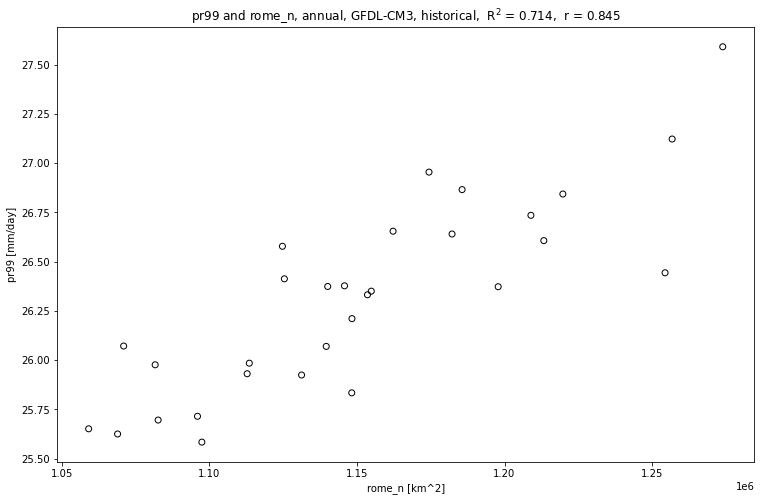

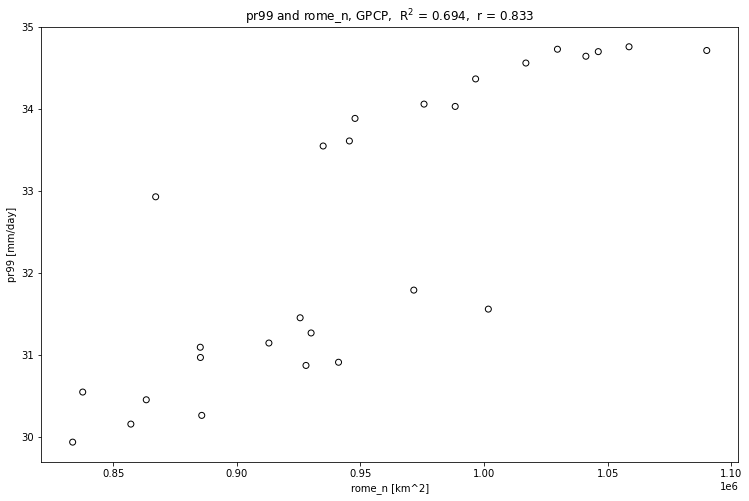

In [31]:
scatter_type = 'annual'
if model:    
    x = org.resample(time='Y').mean(dim='time', keep_attrs=True)
    if prE_option == 'pr99':
        y = prE.resample(time='Y').mean(dim='time', keep_attrs=True)
    else:
        y = prE.mean(dim=('lat','lon'), keep_attrs=True)
    title = prE_option + ' and ' + org_option + ', ' + scatter_type + ', ' + model + ', ' + experiment

    plot_scatter(x,y,title)


if obs:
    x = org_obs.resample(time='Y').mean(dim='time', keep_attrs=True)
    if prE_option == 'pr99':
        y = prE_obs.resample(time='Y').mean(dim='time', keep_attrs=True)
    else:
        y = prE_obs.mean(dim=('lat','lon'), keep_attrs=True)
    title = prE_option + ' and ' + org_option + ', GPCP'

    plot_scatter(x,y,title)

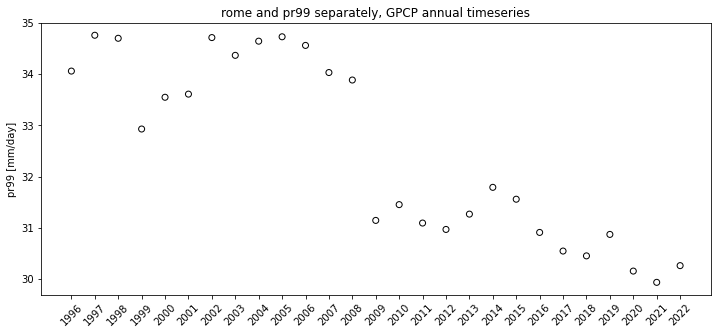

In [32]:
if obs:
    f, ax = plt.subplots(figsize=(12,5))
    folder = home + '/Documents/data/obs/GPCP'
    fileName = 'GPCP_rome.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    x = ds['rome'].resample(time='Y').mean(dim='time', keep_attrs=True)
    years = x.time.dt.year.values

    folder = home + '/Documents/data/obs/GPCP'
    fileName = 'GPCP_pr_percentiles.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    y = ds['pr99'].resample(time='Y').mean(dim='time', keep_attrs=True)

    plt.title('rome and pr99 separately, GPCP annual timeseries')
    plt.xticks(np.arange(0, len(years)), years, rotation=45)

    plot_prE = True
    if plot_prE:
        ax.scatter(np.arange(0,len(y)),y,facecolors='none', edgecolor='k')
        ax.set_ylabel('pr99 [mm/day]')

    plot_org = False
    if plot_org:
        ax2 = ax.twinx()
        ax2.scatter(np.arange(0,len(x)),x,facecolors='none', edgecolor='red')
        ax2.set_ylabel('rome [km$^2$]')
        ax2.yaxis.label.set_color('red')
        ax2.tick_params(axis='y', colors='red')

## daily

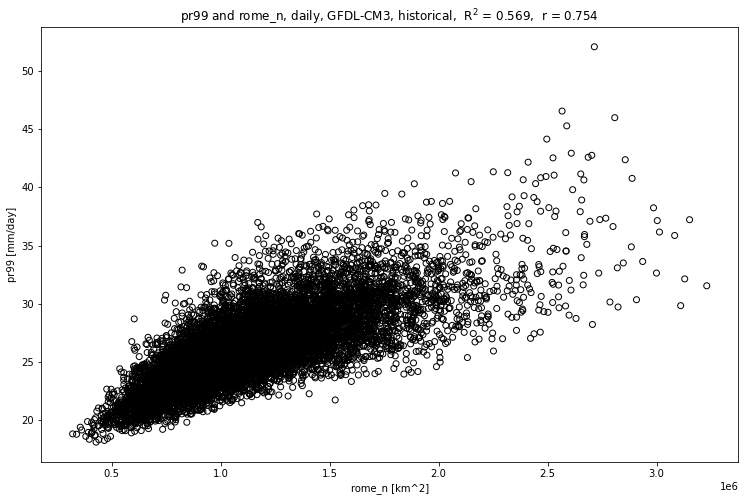

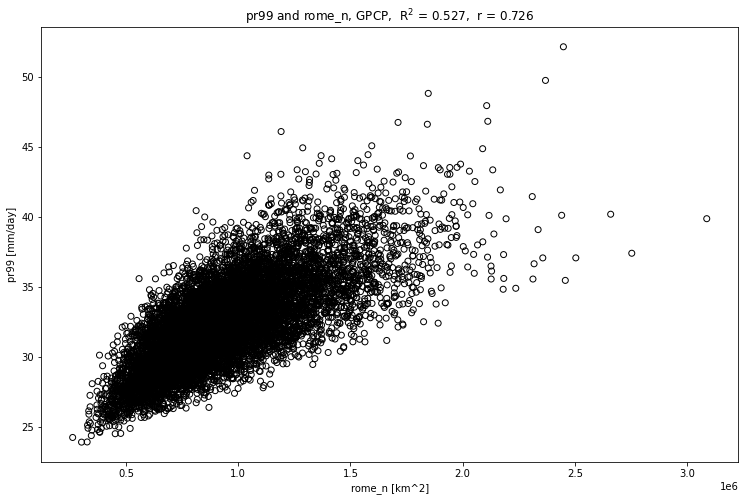

In [33]:
scatter_type = 'daily'
if model:    
    x = org
    if prE_option == 'pr99':
        y = prE
        title = prE_option + ' and ' + org_option + ', ' + scatter_type + ', ' + model + ', ' + experiment
        plot_scatter(x,y,title)


if obs:
    x = org_obs
    if prE_option == 'pr99':
        y = prE_obs
        title = prE_option + ' and ' + org_option + ', GPCP'
        plot_scatter(x,y,title)


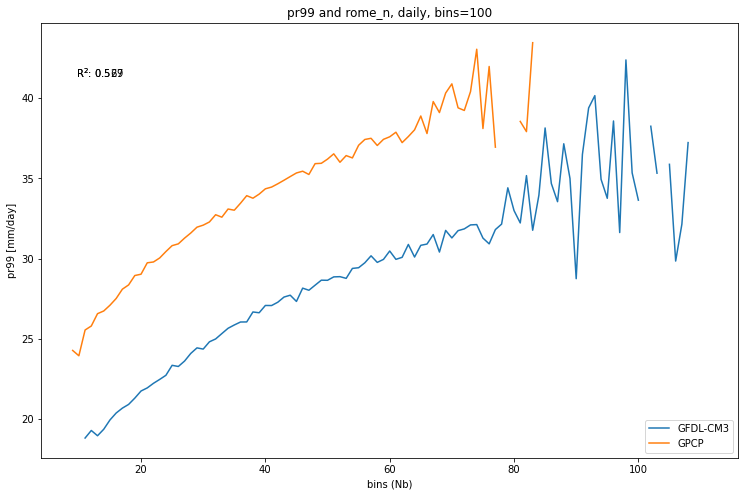

In [34]:
scatter_type = 'daily, bins=100'
plt.figure(figsize = (12.5,8))
ax = plt.gca()
if model:    
    x = org
    if prE_option == 'pr99':
        y = prE
        plot_bins(x,y,title,model)


if obs:
    x = org_obs
    if prE_option == 'pr99':
        y = prE_obs
        title = prE_option + ' and ' + org_option + ', ' + scatter_type
        plot_bins(x,y,title, obs)

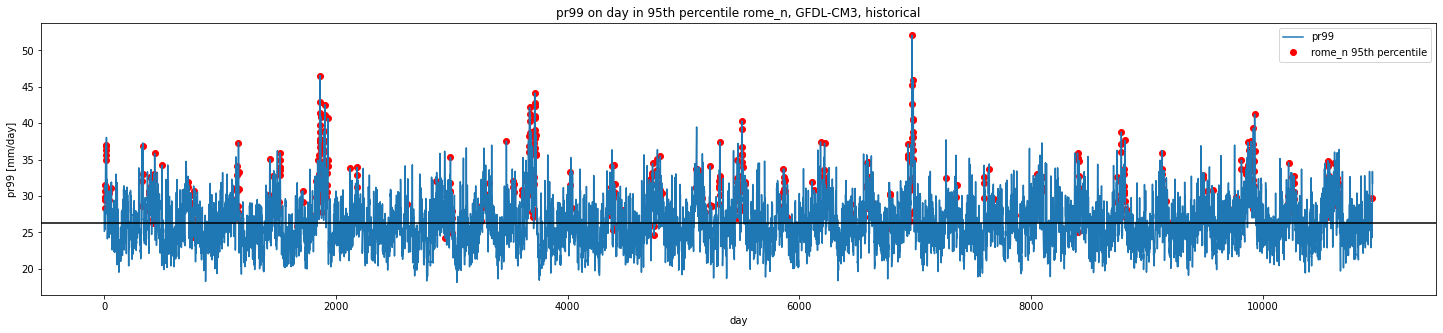

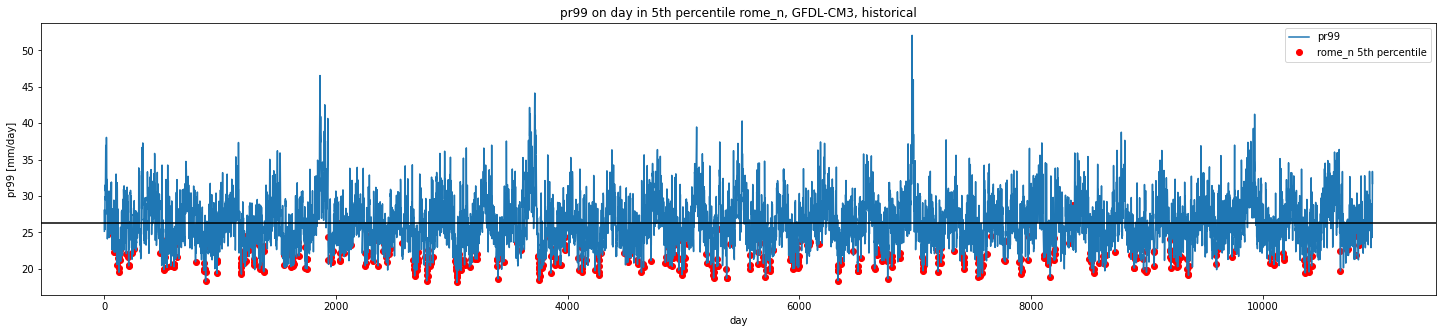

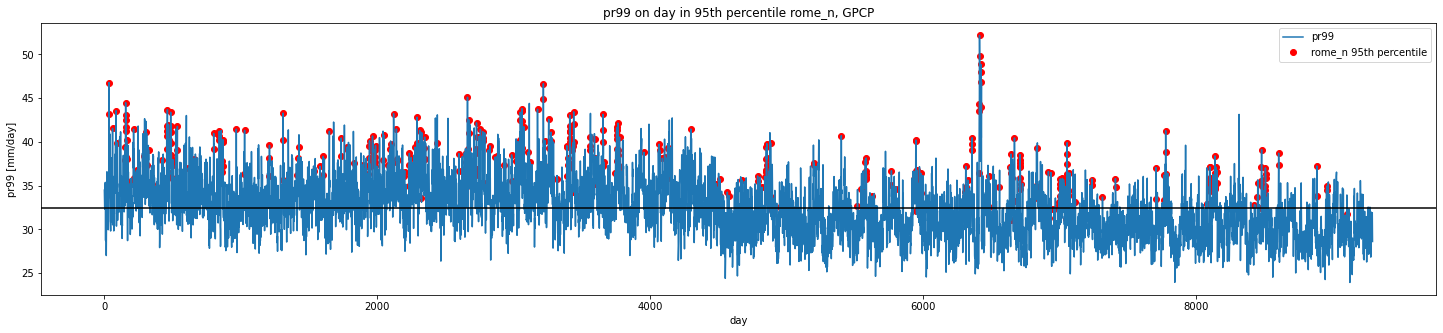

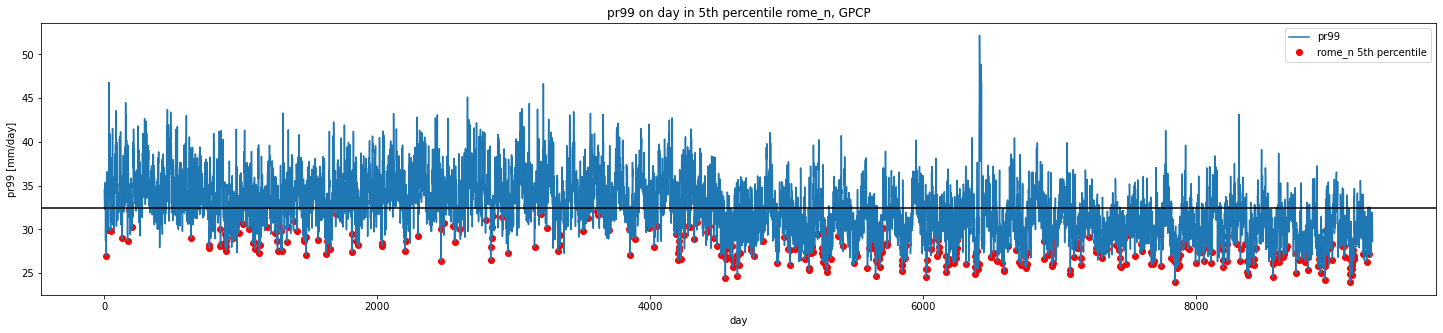

In [35]:
if model:    
    if prE_option == 'pr99':
        series_type = 'day'
        threshold = 95
        org_threshold = np.percentile(org,threshold)
        x = np.argwhere(org.data>=org_threshold)
        y = prE.data
        title = prE_option + ' on ' + series_type + ' in ' + str(threshold) + 'th percentile ' + org_option + ', ' + model + ', ' + experiment

        plot_timeseriesHighlight(x, y, threshold, series_type, title)


        series_type = 'day'
        threshold = 5

        org_threshold = np.percentile(org,threshold)
        x = np.argwhere(org.data<=org_threshold)
        y = prE.data
        title = prE_option + ' on ' + series_type + ' in ' + str(threshold) + 'th percentile ' + org_option + ', ' + model + ', ' + experiment

        plot_timeseriesHighlight(x, y, threshold, series_type, title)


if obs:    
    if prE_option == 'pr99':
        series_type = 'day'
        threshold = 95

        org_threshold = np.percentile(org_obs,threshold)
        x = np.argwhere(org_obs.data>=org_threshold)
        y = prE_obs.data
        title = prE_option + ' on ' + series_type + ' in ' + str(threshold) + 'th percentile ' + org_option + ', GPCP'

        plot_timeseriesHighlight(x, y, threshold, series_type, title)


        series_type = 'day'
        threshold = 5

        org_threshold = np.percentile(org_obs,threshold)
        x = np.argwhere(org_obs.data<=org_threshold)
        y = prE_obs.data
        title = prE_option + ' on ' + series_type + ' in ' + str(threshold) + 'th percentile ' + org_option + ', GPCP'

        plot_timeseriesHighlight(x, y, threshold, series_type, title)

## other

### monthly

In [36]:
# scatter_type = 'monthly'
# if model:    
#     x = org.resample(time='M').mean(dim='time', keep_attrs=True)
#     if prE_option == 'pr99':
#         y = prE.resample(time='M').mean(dim='time', keep_attrs=True)
#         title = prE_option + ' and ' + org_option + ', ' + scatter_type + ', ' + model + ', ' + experiment
#         plot_scatter(x,y,title)


# if obs:
#     x = org_obs.resample(time='M').mean(dim='time', keep_attrs=True)
#     if prE_option == 'pr99':
#         y = prE_obs.resample(time='M').mean(dim='time', keep_attrs=True)
#         title = prE_option + ' and ' + org_option + ', GPCP'
#         plot_scatter(x,y,title)